In [1]:
import os
from PIL import Image, ImageFile, PngImagePlugin
Image.MAX_IMAGE_PIXELS = None 
PngImagePlugin.MAX_TEXT_CHUNK = 100 * 1024 * 1024  # 100MB
PngImagePlugin.MAX_TEXT_MEMORY = 100 * 1024 * 1024 # 100MB

ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
from pathlib import Path

dataDir = Path("/media/toom/New Volume/cuhk_data/HPACG_dataHPACG_split")
train_positive_dir = dataDir / "train/positive"
train_negative_dir = dataDir / "train/negative"

test_positive_dir = dataDir / "test/positive"
test_negative_dir = dataDir / "test/negative"

def get_random_img_path():
    rand_img = random.choice(os.listdir(dataDir / "train/positive"))
    rand_img_full_path = dataDir / "train/positive" / rand_img

    return rand_img_full_path

import os
import logging
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import timm
from os.path import join as pjoin
import json
from torchvision.transforms.functional import to_pil_image
import matplotlib as plt

In [2]:
from trident.patch_encoder_models import encoder_factory

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
import numpy as np

import scipy.ndimage
import matplotlib.pyplot as plt

In [4]:
def get_model():
    model = encoder_factory(model_name='conch_v15')

    def get_eval_transforms_conchv1_5(img_resize: int = 448):
        transform = transforms.Compose(
            [
                transforms.Resize(
                    img_resize, interpolation=transforms.InterpolationMode.BICUBIC
                ),
                transforms.CenterCrop(img_resize),
                transforms.Lambda(
                    lambda img: img.convert("RGB") if img.mode != "RGB" else img
                ),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ]
        )
        return transform

    transform = get_eval_transforms_conchv1_5()

    return model, transform

def run_model_and_generate_attention_mask(img_path):
    model, transform = get_model()
    model.to('cpu')
    _ = model.eval()

    img = Image.open(img_path).convert("RGB")
    o_img = img.copy()
    img = transform(img).unsqueeze(dim=0).to('cpu')

    attention_scores = []
    hooks = []

    def get_attention_matrix(module, input, output):
        attention_scores.append(output.detach().cpu())

    for i in range(24):
        target_layer = model.model.trunk.blocks[i].attn
        hook = target_layer.register_forward_hook(get_attention_matrix)
        hooks.append(hook)

    # block = model.model.trunk.blocks[-1]
    # def block_hook(module, input, output):
    #     print("Block executed!")
    #     print(f"Input shape: {input[0].shape}")
    # handle = block.register_forward_hook(block_hook)

    _ = model(img)

    for hook in hooks:
        hook.remove()

    o_img = np.array(o_img)
    attentions = attention_scores[-1][:, 1:, :]
    heatmap = torch.norm(attentions, dim=-1)
    heatmap = heatmap.reshape(28, 28).detach().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = heatmap ** 4
    # heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    smoothed_heatmap = scipy.ndimage.gaussian_filter(heatmap, sigma=1.5)
    smoothed_heatmap = cv2.resize(smoothed_heatmap, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
    # smoothed_heatmap[smoothed_heatmap < smoothed_heatmap.mean()] *= 0.7
    H, W = smoothed_heatmap.shape

    overlay = np.zeros((H, W, 4))

    overlay[..., 0] = 1.0  # Red
    overlay[..., 1] = 0.0  # Green
    overlay[..., 2] = 0.0  # Blue
    overlay[..., 3] = smoothed_heatmap 

    def plot_side_by_side(img, overlay):
        # Create a figure with 1 row and 2 columns
        fig, axes = plt.subplots(1, 3, figsize=(12, 6))

        # Plot first image
        axes[0].imshow(img)
        axes[0].set_title("Input")
        axes[0].axis('off') # Hide tick numbers

        # Plot second image
        axes[1].imshow(img)
        axes[1].imshow(overlay)
        axes[1].set_title("Overlay")
        axes[1].axis('off')

        axes[2].imshow(overlay)
        axes[2].set_title("Attention Mask")
        axes[2].axis('off')

        plt.tight_layout() # Adjusts spacing so they don't overlap
        plt.show()

    # Usage
    plot_side_by_side(o_img, overlay)

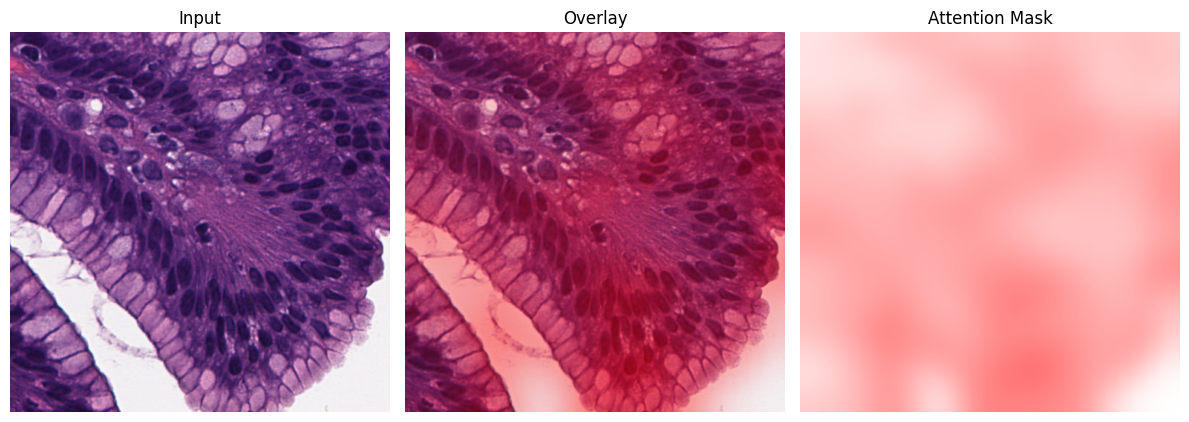

In [5]:
run_model_and_generate_attention_mask("./test_img.png")

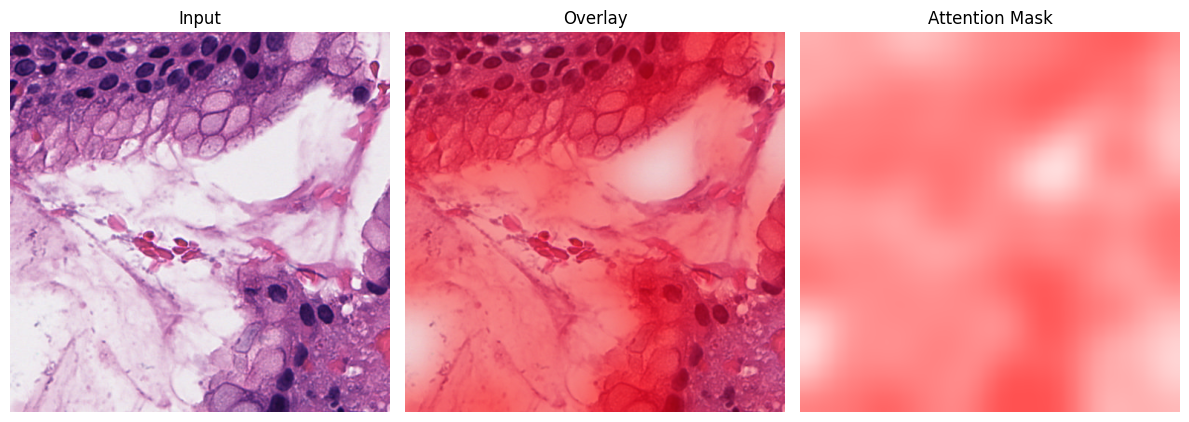

In [6]:
run_model_and_generate_attention_mask(get_random_img_path())

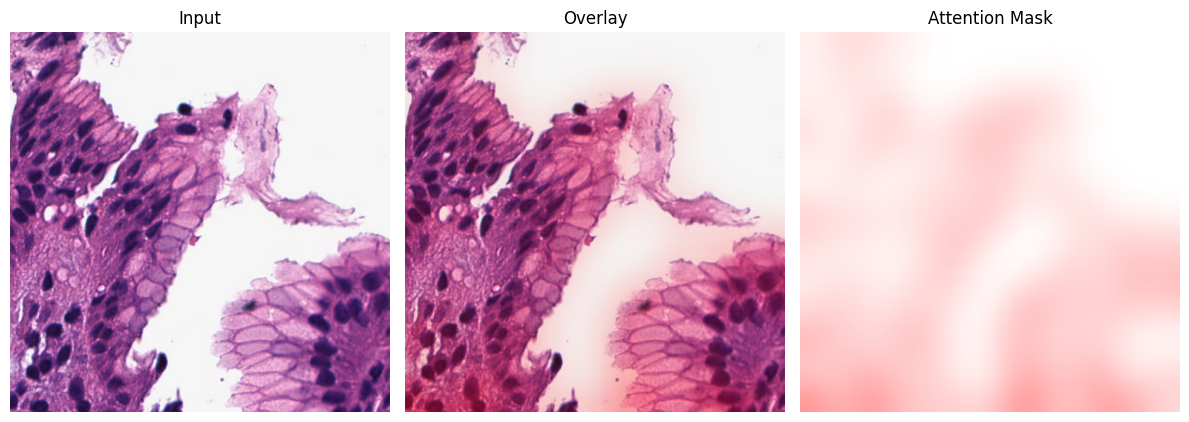

In [7]:
run_model_and_generate_attention_mask(get_random_img_path())

In [ ]:
# https://medium.com/@nivonl/exploring-visual-attention-in-transformer-models-ab538c06083a

In [ ]:
def attention_rollout(attentions):
    # Initialize rollout with identity matrix
    device = attentions[0].device
    rollout = torch.eye(28).to(device)

    # Multiply attention maps layer by layer
    for attention in attentions:
        attention = attention[:, 1:, :]
        attention = attention.reshape(28, 28, 1024)
        attention_heads_fused = attention.mean(dim=-1) # Average attention across heads
        attention_heads_fused += torch.eye(28).to(device) # A + I
        attention_heads_fused /= attention_heads_fused.sum(dim=1, keepdim=True) # Normalizing A
        rollout = torch.matmul(rollout, attention_heads_fused) # Multiplication
        break

    return rollout

# cls_attention = attention_rollout(attention_scores[:])
# cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())

# plt.imshow(cls_attention, cmap='gray')